## Basic Model

Let's get a basic model up-and-running. 

After we've implemented it here, we can move to `src/main.py` for a proper K-folds training loop.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#from fastai import
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from functools import partial
from sklearn.model_selection import train_test_split

import torch

import fastai
from fastai.torch_core import grab_idx
from fastai.core import subplots, split_kwargs_by_func
from fastai.basic_train import RecordOnCPU
from fastai.layers import BCEWithLogitsFlat
from fastai.vision import unet_learner, models, DatasetType
from fastai.vision import lr_find
from fastai.vision import Path, get_image_files, open_image, open_mask, SegmentationItemList, get_transforms, imagenet_stats
from fastai.metrics import dice
from fastai.vision import ResizeMethod
from fastai.vision import ImageSegment, SegmentationLabelList, pil2tensor

from src.utils import multiclass_dice, multiclass_dice_threshold, get_training_image_size, rle_decode, overrideOpenMask

Note that we're using images of size `350x525` but we're training with images of size `352x544`. This is because UNet has a [hard requirement](https://forums.fast.ai/t/in-dynamicunet-learner-export-will-fail-if-set-dataloader-transform-size-some-odd-number/54926) that its inputs be multiple of `32`.

In [3]:
DATA = Path('data')
TRAIN = DATA/"train.csv"
TEST = DATA/"sample_submission.csv"

size = (350,525)
training_image_size = get_training_image_size(size)     #UNet requires that inputs are multiples of 32
#If we want to train on smaller images, we can add their suffix here
SUFFIX = "_" + str(size[0]) + "x" + str(size[1])        #eg. _350x525
batch_size=8

path = Path('data')
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
test['label'] = test['Image_Label'].apply(lambda x: x.split('_')[1])
test['im_id'] = test['Image_Label'].apply(lambda x: x.split('_')[0])

Since every images is duplicated 4 times (once for each class) let's get a dataframe with only unique images.

In [4]:
unique_images = train.iloc[::4, :]
unique_test_images = test.iloc[::4, :]

In [5]:
# Our masks were converted from four run-length encodings into 4-channel masks. 
# For the sake of convenience, I've saved these masks as RGBA .png images on disks

# Use a custom approach for opening masks as RGBA
overrideOpenMask()

In [6]:
def get_y_fn(x):
    # Given a path to a training image, build the corresponding mask path
    split = x.split('/')
    newPath = DATA/("train_images_annots" + SUFFIX)/split[-1].replace('.jpg','.png')
    return newPath

codes = np.array(['Fish', 'Flower', 'Gravel', 'Sugar'])

In [7]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)

In [8]:
def isValid(img_id):
    filename = img_id.split('/')[-1]
    return str(filename) in valid_ids

In [9]:
src = (SegmentationItemList.from_df(unique_images[:3000], path/'train_images_350x525', cols='im_id')
       .split_by_valid_func(isValid)
       .label_from_func(get_y_fn, classes=codes))

In [10]:
transforms = get_transforms()

In [11]:
data = (src.transform(transforms, tfm_y=True, size=training_image_size, resize_method=ResizeMethod.PAD, padding_mode="zeros")
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

We would like to plot the masks over the images to sanity check whether or not we've created them correctly. We'll create our own custom `show_batch()` method that also keeps track of the filepath of the images in a batch. Then we can compare these images to the original masks.

In [12]:
def flattenImageSegment(imSegment):
    
    imTensor = imSegment.data
    
    imTensor[0,:] = imTensor[0,:] * 1
    imTensor[1,:] = imTensor[1,:] * 2
    imTensor[2,:] = imTensor[2,:] * 3
    imTensor[3,:] = imTensor[3,:] * 4
    
    flat = imTensor.float().sum(dim=0)
    flat = flat.unsqueeze(0)
    
    return ImageSegment(flat)

def custom_show_batch(data, imgsize=4, rows=2):
    n_items = 6
    rows = 2

    # Get the filenames 
    filenames = data.train_ds.items[:n_items]

    # Get the images after data augmentation
    items = data.train_ds[:n_items]
    xs, ys = list(zip(*items))

    axs = subplots(rows, rows, imgsize=imgsize)

    for fn,x,y,ax in zip(filenames, xs, ys, axs.flatten()): 
        flatY = flattenImageSegment(y)
        x.show(ax=ax, y=flatY, title=fn)

    for ax in axs.flatten()[len(xs):]: 
        ax.axis('off')

    plt.tight_layout()

This is the original code to visualize the masks:

In [13]:
def plotImage(im_id):

    fig = plt.figure(figsize=(25, 16))
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
        im = Image.open(f"data/train_images/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        if isinstance(mask_rle, str):
            mask = rle_decode(mask_rle)
        else:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

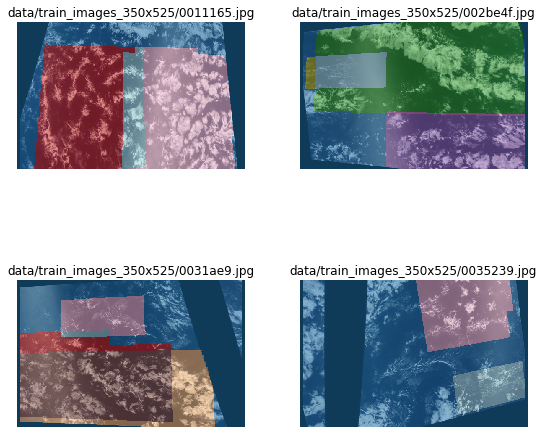

In [14]:
custom_show_batch(data)

We can compare these to the original images and masks to make sure everything is working:

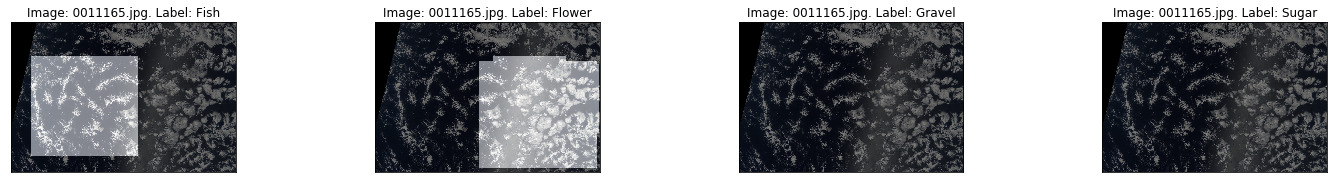

In [15]:
plotImage('0011165.jpg')

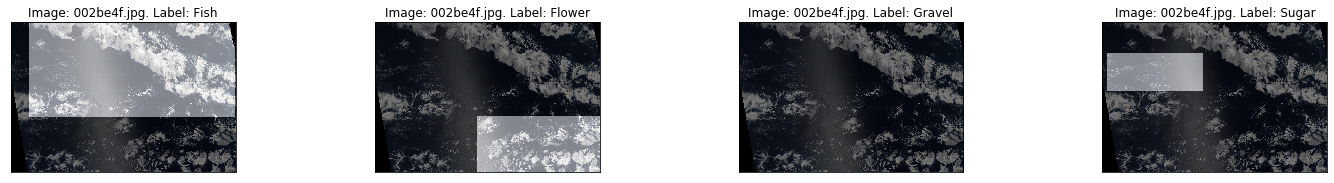

In [16]:
plotImage('002be4f.jpg')

We are going to use two metrics to keep an eye on our model's performance during training: 
 - `multiclass_dice`
 - `multiclass_dice_threshold` with a threshold value of `0.5`

In [18]:
dice_50 = partial(multiclass_dice_threshold, threshold=0.50)
learn = unet_learner(data, models.xresnet18, pretrained=False, metrics=[multiclass_dice, dice_50], loss_func=BCEWithLogitsFlat(), model_dir=path).mixup(stack_y=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


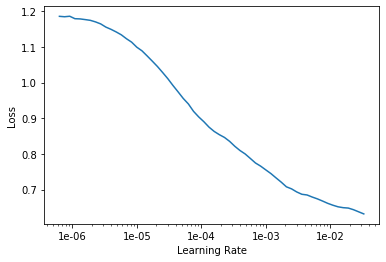

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr=3e-3

In [21]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,multiclass_dice,multiclass_dice_threshold,time
0,0.428626,0.403263,0.169402,0.000000,03:40
1,0.388368,0.389488,0.169257,0.000000,03:38
2,0.389666,0.385306,0.174460,0.000000,03:36


In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,multiclass_dice,multiclass_dice_threshold,time
0,0.392768,0.385290,0.174330,0.000000,03:36
1,0.393667,0.391642,0.186450,0.000000,03:37
2,0.387932,0.386993,0.181778,0.000006,03:50
3,0.391252,0.386801,0.183653,0.000001,03:59
4,0.388219,0.386858,0.165680,0.000000,03:59
5,0.387336,0.384772,0.180392,0.000000,03:59
6,0.382984,0.381593,0.176966,0.000000,03:54
7,0.389766,0.383166,0.187340,0.000000,03:53
8,0.378453,0.380671,0.180977,0.000000,03:57
9,0.383045,0.380881,0.183390,0.000000,03:50
